<a href="https://colab.research.google.com/github/geosensing/streetsense2/blob/main/get_streetview_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import time
import random
import requests
import shapefile
import numpy as np
from urllib.parse import urlencode
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [2]:
# Load the shapefile (both .shp and .dbf should be in the same directory)
shp_path = "../shape_files/gadm41_IND_2.shp"  # Update path if needed
sf = shapefile.Reader(shp_path)

# Extract the fields and records
fields = [field[0] for field in sf.fields[1:]]  # Ignore first field ('DeletionFlag')
records = sf.records()

# Find the index of the "NAME_2" field (which contains "Mumbai City")
name_index = fields.index("NAME_2")  

# Extract polylines for "NCT of Delhi"
delhi_shapes = [shape for record, shape in zip(records, sf.shapes()) if record[name_index] == "Mumbai City"]

# Get bounding box (min_x, min_y, max_x, max_y)
all_points = [point for shape in delhi_shapes for point in shape.points]
min_x = min(p[0] for p in all_points)
min_y = min(p[1] for p in all_points)
max_x = max(p[0] for p in all_points)
max_y = max(p[1] for p in all_points)

In [3]:
# Construct BBBike extract URL
bbbike_url = f"http://extract.bbbike.org/?sw_lng={min_x}&sw_lat={min_y}&ne_lng={max_x}&ne_lat={max_y}"
print("BBBike Extract URL:", bbbike_url)

BBBike Extract URL: http://extract.bbbike.org/?sw_lng=72.79152679500004&sw_lat=18.890695572000084&ne_lng=72.88465118300002&ne_lat=19.05473518399998


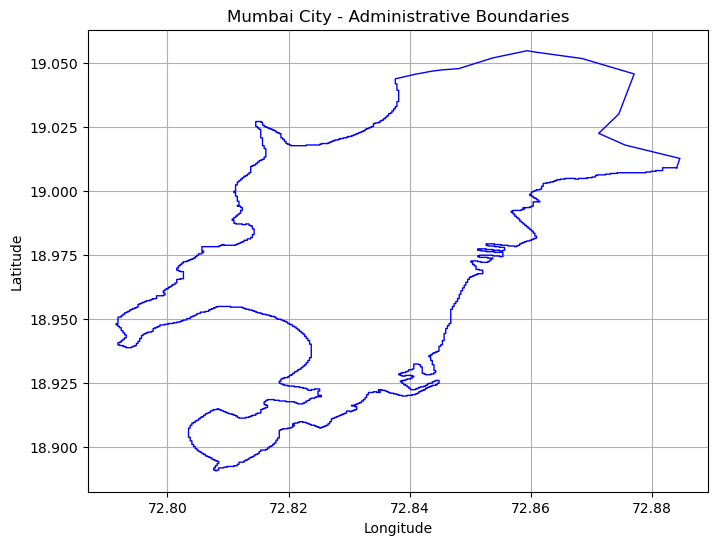

In [4]:
# Plot Mumbai map
plt.figure(figsize=(8, 6))
for shape in delhi_shapes:
    x, y = zip(*shape.points)  # Extract x and y coordinates
    plt.plot(x, y, 'b', linewidth=1)

plt.title("Mumbai City - Administrative Boundaries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [5]:
# Load the roads shapefile
roads_shp_path = "../shape_files/IND_IND.20_1+Mumbai City_roads.shp"  # Update path if needed
sf = shapefile.Reader(roads_shp_path)

# Extract fields and records
fields = [field[0] for field in sf.fields[1:]]  # Skip first field ('DeletionFlag')
records = sf.records()

# Inspect field names to find relevant ones
print("Fields in shapefile:", fields)

Fields in shapefile: ['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed']


In [6]:
# Assume "road_type" or similar field exists; update this based on inspection
road_type_field = "type"  # Update if needed
road_type_index = fields.index(road_type_field)

unique_road_types = set(record[road_type_index] for record in sf.records())
print("Unique road types in shapefile:", unique_road_types)

Unique road types in shapefile: {'motorway', 'primary_link', 'living_street', 'trunk', 'steps', 'unclassified', 'secondary_link', 'motorway_link', 'track', 'path', 'proposed', 'services', 'footway', 'construction', 'primary', 'tertiary_link', 'service', 'secondary', 'residential', 'pedestrian', 'tertiary', 'trunk_link'}


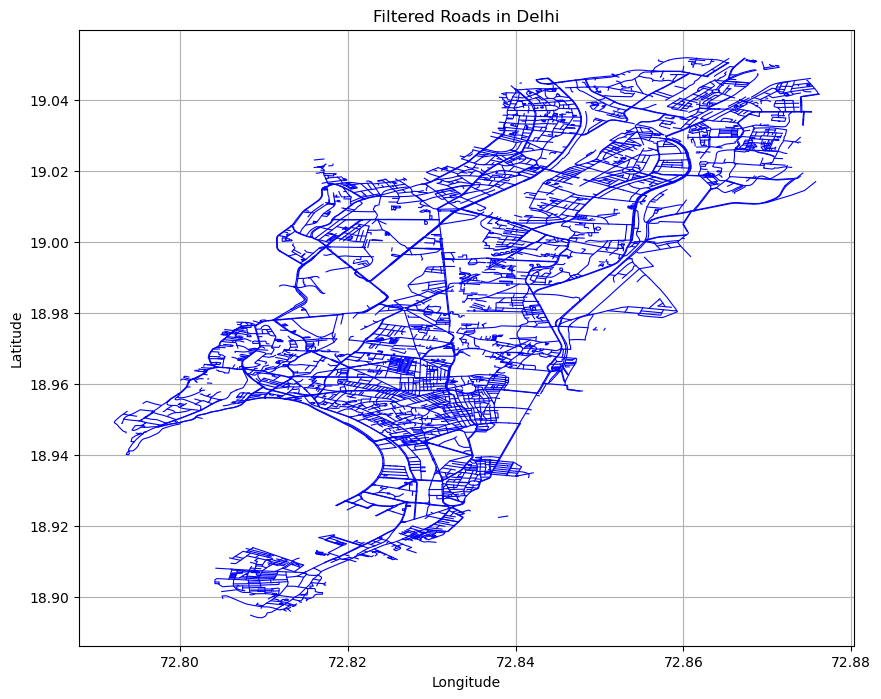

In [7]:
# Define road types to filter (e.g., "highway", "main road", "primary road")
road_types_of_interest = ["residential", "primary", "secondary", "tertiary"]

# Extract roads of interest
selected_roads = [shape for record, shape in zip(records, sf.shapes()) if record[road_type_index] in road_types_of_interest]
#selected_roads = [shape for record, shape in zip(records, sf.shapes())]

# Plot the selected roads
plt.figure(figsize=(10, 8))

for shape in selected_roads:
    x, y = zip(*shape.points)  # Extract coordinates
    plt.plot(x, y, 'b', linewidth=0.8)  # Plot with blue color

plt.title("Filtered Roads in Delhi")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [8]:
# Extract field names
fields = [field[0] for field in sf.fields[1:]]  # Ignore DeletionFlag
print("Fields:", fields)  # Identify road type field

# Extract road data into a DataFrame
road_data = []
#for record, shape in zip(sf.records(), sf.shapes()):
for record, shape in zip(sf.records(), sf.shapes()):
    if record[road_type_index] not in road_types_of_interest:
        continue
    if shape.shapeType == 3:  # Ensure it's a polyline
        start_lat, start_long = shape.points[0]
        end_lat, end_long = shape.points[-1]
        road_data.append(list(record) + [start_lat, start_long, end_lat, end_long])

# Create DataFrame
df_roads = pd.DataFrame(road_data, columns=fields + ["start_lat", "start_long", "end_lat", "end_long"])

# Display sample
df_roads.head()

Fields: ['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed']


,osm_id,name,ref,type,oneway,bridge,maxspeed,start_lat,start_long,end_lat,end_long
0,22845315,Badaruddin Tayabji Marg,,tertiary,0,0,NaN,72.830680,18.942550,72.832707,18.944611
1,22845318,Homi Modi Street,,residential,1,0,NaN,72.831716,18.931634,72.834059,18.931166
2,22845331,Jeejeebhoy Dadabhoy Lane,,residential,0,0,NaN,72.835407,18.936243,72.833872,18.936409
3,22845332,Kumtha Street,,residential,0,0,NaN,72.840520,18.935936,72.839395,18.936174
4,22845343,Viju Kotak Marg,,residential,0,0,NaN,72.839039,18.936844,72.836951,18.937318


In [9]:
def haversine(lat1, lon1, lat2, lon2):
    """Compute the Haversine distance (in meters) between two lat/lon points."""
    R = 6371000  # Earth's radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in meters

In [12]:
df_roads["LENGTH_M"] = df_roads.apply(
    lambda row: haversine(row["start_lat"], row["start_long"], row["end_lat"], row["end_long"]),
    axis=1
)

# Check length distribution
print(df_roads["LENGTH_M"].describe())

count    5517.000000
mean      100.406768
std       125.092815
min         0.000000
25%        21.600474
50%        56.868614
75%       131.441317
max      1421.835564
Name: LENGTH_M, dtype: float64


In [13]:
def split_road_segment(row, segment_length=500):
    """Splits a road segment into equal chunks of segment_length (in meters)."""
    road_length = row["LENGTH_M"]
    
    if road_length <= segment_length:
        return [row.to_dict()]  # Return original row as a list to avoid NaNs

    num_segments = int(np.ceil(road_length / segment_length))  # Number of 500m chunks

    start_lat, start_long = row["start_lat"], row["start_long"]
    end_lat, end_long = row["end_lat"], row["end_long"]

    lat_step = (end_lat - start_lat) / num_segments
    long_step = (end_long - start_long) / num_segments

    split_segments = []
    for i in range(num_segments):
        new_start_lat = start_lat + (i * lat_step)
        new_start_long = start_long + (i * long_step)
        new_end_lat = new_start_lat + lat_step
        new_end_long = new_start_long + long_step

        new_segment = row.to_dict()
        new_segment["start_lat"] = new_start_lat
        new_segment["start_long"] = new_start_long
        new_segment["end_lat"] = new_end_lat
        new_segment["end_long"] = new_end_long
        new_segment["SEGMENT_PART"] = i + 1
        new_segment["LENGTH_M"] = segment_length  # Set length to 500m

        split_segments.append(new_segment)

    return split_segments

In [14]:
df_long_roads = df_roads[df_roads["LENGTH_M"] > 500]
df_short_roads = df_roads[df_roads["LENGTH_M"] <= 500]

# Apply fixed chunking function
df_long_roads_split = df_long_roads.apply(split_road_segment, axis=1)

# Ensure list format before explode()
df_long_roads_split = df_long_roads_split.explode().reset_index(drop=True)

# Convert dictionaries back to DataFrame
df_long_roads_split = pd.DataFrame(list(df_long_roads_split))

# Combine back
df_roads_final = pd.concat([df_short_roads, df_long_roads_split], ignore_index=True)

print("✅ Roads successfully chunked into 500m segments!")

✅ Roads successfully chunked into 500m segments!


In [15]:
# Randomly sample 1000 roads
df_sampled = df_roads_final.sample(n=100, random_state=42)  # Change `n` if needed

df_sampled.head()

,osm_id,name,ref,type,oneway,bridge,maxspeed,start_lat,start_long,end_lat,end_long,LENGTH_M,SEGMENT_PART
3494,1139162523,Dr Madhukar B. Raut Marg,,residential,0,0,NaN,72.839785,19.025565,72.839848,19.025635,7.354409,NaN
1609,214699887,,,residential,0,0,NaN,72.811603,18.906561,72.809711,18.906770,210.426626,NaN
1097,42879186,Nathalal M Parekh Marg,,residential,1,0,NaN,72.855848,19.026484,72.856934,19.025663,123.768756,NaN
2302,658655413,Dr Annie Besant Road,,primary,1,0,NaN,72.813966,18.990332,72.814015,18.990626,11.087055,NaN
4500,1235771381,Flank Road,,tertiary,0,0,NaN,72.865169,19.037447,72.867013,19.039603,216.900199,NaN


In [16]:
def add_google_maps_links(df):
    """
    Add Google Maps links to a DataFrame with latitude and longitude columns.
    
    Args:
        df (pandas.DataFrame): DataFrame with 'start_lat' and 'start_long' columns
        
    Returns:
        pandas.DataFrame: Original DataFrame with added 'maps_link' column
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Create Google Maps links
    result_df['maps_link'] = result_df.apply(
        lambda row: f"https://www.google.com/maps?q={row['start_long']},{row['start_lat']}", 
        axis=1
    )
    
    return result_df

# Apply to your DataFrame
df_with_links = add_google_maps_links(df_sampled)

# Display the first few rows
print(df_with_links[['start_lat', 'start_long', 'maps_link']].head())

      start_lat  start_long                                          maps_link
3494  72.839785   19.025565  https://www.google.com/maps?q=19.0255655,72.83...
1609  72.811603   18.906561  https://www.google.com/maps?q=18.9065607,72.81...
1097  72.855848   19.026484  https://www.google.com/maps?q=19.0264845,72.85...
2302  72.813966   18.990332  https://www.google.com/maps?q=18.9903318,72.81...
4500  72.865169   19.037447  https://www.google.com/maps?q=19.0374469,72.86...


In [17]:
def fetch_street_view_images(df, api_key, output_dir="../sv_images/mumbai/", 
                                   points_per_segment=3, images_per_point=2, max_workers=3):
    """
    Fetch Google Street View images for coordinates in a DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame with 'start_lat', 'start_long' columns
        api_key (str): Your Google API key with Street View Static API enabled
        output_dir (str): Directory to save the images
        points_per_segment (int): Number of points to sample along each segment
        images_per_point (int): Number of images to take at each point (with different angles)
        max_workers (int): Maximum number of parallel workers
        
    Returns:
        pandas.DataFrame: Results with image details
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    results = []
    
    # Process each row in the DataFrame
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        
        for idx, row in df.iterrows():
            future = executor.submit(
                _process_location, idx, row, api_key, output_dir, 
                points_per_segment, images_per_point
            )
            futures.append(future)
            
        # Process results as they complete
        for future in tqdm(futures, total=len(futures), desc="Processing locations"):
            location_results = future.result()
            results.extend(location_results)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV
    results_csv = os.path.join(output_dir, '../sv_images/sv_results_mumbai.csv')
    results_df.to_csv(results_csv, index=False)
    
    # Print summary
    success_count = results_df['success'].sum() if 'success' in results_df.columns else 0
    total_count = len(results_df)
    print(f"Successfully fetched {success_count} of {total_count} images "
          f"({success_count/total_count*100:.1f}%)")
    print(f"Results saved to {results_csv}")
    
    return results_df

def _process_location(idx, row, api_key, output_dir, points_per_segment, images_per_point):
    """Process a single location/road segment."""
    results = []
    
    # Get coordinates (as-is from the DataFrame)
    start_lat = row['start_lat']
    start_long = row['start_long']
    
    # Get end coordinates if available
    end_lat = row.get('end_lat', start_lat)
    end_long = row.get('end_long', start_long)
    
    # Interpolate points along the segment
    points = _interpolate_points(
        start_lat, start_long, end_lat, end_long, points_per_segment
    )
    
    for point_idx, (lat, lng) in enumerate(points):
        # Print the coordinates we're checking
        print(f"Checking location {idx}, point {point_idx}: Lat {lat}, Long {lng}")
        
        # For Google Maps URL, we use the format lat,lng
        maps_url = f"https://www.google.com/maps?q={lat},{lng}"
        print(f"Google Maps URL: {maps_url}")
        
        # For Google Street View API, we also use the format lat,lng
        sv_available = _has_street_view_imagery(lat, lng, api_key)
        if not sv_available:
            print(f"No Street View imagery available at this location")
            continue
            
        for img_idx in range(images_per_point):
            # Generate random viewing angles
            heading = random.randint(0, 359)
            pitch = int((random.random() - 0.5) * 60)  # Between -30 and 30 degrees
            
            # Build Street View URL
            url = _build_street_view_url(lat, lng, heading, pitch, api_key)
            
            # Generate filename
            filename = os.path.join(
                output_dir,
                f"loc_{idx}_point_{point_idx}_img_{img_idx}_h{heading}_p{pitch}.jpg"
            )
            
            # Fetch and save the image
            print(f"Fetching image {img_idx} with heading {heading}° and pitch {pitch}°...")
            success = _fetch_image(url, filename)
            
            if success:
                print(f"Successfully saved image to {filename}")
            else:
                print(f"Failed to save image")
            
            # Record the result
            result = {
                'location_index': idx,
                'point_index': point_idx,
                'image_index': img_idx,
                'lat': lat,
                'lng': lng,
                'heading': heading,
                'pitch': pitch,
                'filename': filename if success else None,
                'success': success,
                'maps_url': maps_url
            }
            
            # Add original row data
            for col in row.index:
                if col not in ['start_lat', 'start_long', 'end_lat', 'end_long']:
                    result[col] = row[col]
            
            results.append(result)
            
            # Add a small delay to avoid hitting API rate limits
            time.sleep(0.2)
    
    return results

def _interpolate_points(start_lat, start_long, end_lat, end_long, num_points=3):
    """Interpolate points along a line between start and end coordinates."""
    if num_points < 2:
        return [(start_lat, start_long)]
        
    points = []
    for i in range(num_points):
        # Calculate fraction of the way from start to end
        fraction = i / (num_points - 1)
        
        # Linear interpolation
        lat = start_lat + fraction * (end_lat - start_lat)
        lng = start_long + fraction * (end_long - start_long)
        
        points.append((lat, lng))
        
    return points

def _has_street_view_imagery(lat, lng, api_key):
    """Check if a location has Street View imagery available."""
    params = {
        'location': f"{lat},{lng}",
        'key': api_key
    }
    
    url = f"https://maps.googleapis.com/maps/api/streetview/metadata?{urlencode(params)}"
    
    try:
        response = requests.get(url, timeout=5)
        data = response.json()
        
        # Check if the status is OK, indicating imagery is available
        return data.get('status') == 'OK'
    except Exception as e:
        print(f"Error checking Street View metadata: {e}")
        return False

def _build_street_view_url(lat, lng, heading, pitch, api_key, size="600x400", fov=90):
    """Build a Google Street View image URL."""
    params = {
        'size': size,
        'location': f"{lat},{lng}",
        'heading': heading,
        'pitch': pitch,
        'fov': fov,
        'key': api_key
    }
    
    return f"https://maps.googleapis.com/maps/api/streetview?{urlencode(params)}"

def _fetch_image(url, filename):
    """Fetch an image from a URL and save it to disk."""
    try:
        response = requests.get(url, timeout=10)
        
        # Check if we got a valid image (not the "no image" placeholder)
        if response.status_code == 200 and len(response.content) > 5000:
            with open(filename, 'wb') as f:
                f.write(response.content)
            return True
        
        if response.status_code != 200:
            print(f"Error status code: {response.status_code}")
        elif len(response.content) <= 5000:
            print(f"Image too small ({len(response.content)} bytes), likely a placeholder")
            
        return False
    except Exception as e:
        print(f"Error fetching image: {e}")
        return False

In [18]:
df_fixed = df_sampled.copy()

# Swap the lat/long columns
df_fixed['temp'] = df_fixed['start_lat']
df_fixed['start_lat'] = df_fixed['start_long']
df_fixed['start_long'] = df_fixed['temp']
df_fixed.drop('temp', axis=1, inplace=True)

# Do the same for end coordinates if they exist
if 'end_lat' in df_fixed.columns and 'end_long' in df_fixed.columns:
    df_fixed['temp'] = df_fixed['end_lat']
    df_fixed['end_lat'] = df_fixed['end_long']
    df_fixed['end_long'] = df_fixed['temp']
    df_fixed.drop('temp', axis=1, inplace=True)

# Print the first few rows to verify the swap
print(df_fixed[['start_lat', 'start_long']].head())

      start_lat  start_long
3494  19.025565   72.839785
1609  18.906561   72.811603
1097  19.026484   72.855848
2302  18.990332   72.813966
4500  19.037447   72.865169


In [19]:
with open("google_api.txt", 'r') as f:
    API_KEY = f.read().strip()

# Fetch Street View images
results = fetch_street_view_images(
    df=df_fixed,
    api_key=API_KEY,
    points_per_segment=1, 
    images_per_point=1
)

Checking location 3494, point 0: Lat 19.0255655, Long 72.8397849
Google Maps URL: https://www.google.com/maps?q=19.0255655,72.8397849
Checking location 1609, point 0: Lat 18.9065607, Long 72.8116026
Google Maps URL: https://www.google.com/maps?q=18.9065607,72.8116026
Checking location 1097, point 0: Lat 19.0264845, Long 72.8558476
Google Maps URL: https://www.google.com/maps?q=19.0264845,72.8558476


Processing locations:   0%|                             | 0/100 [00:00<?, ?it/s]

No Street View imagery available at this location
Checking location 2302, point 0: Lat 18.9903318, Long 72.8139662
Google Maps URL: https://www.google.com/maps?q=18.9903318,72.8139662
Fetching image 0 with heading 91° and pitch 9°...
Fetching image 0 with heading 69° and pitch -4°...
Fetching image 0 with heading 243° and pitch 14°...
Successfully saved image to ../sv_images/loc_1097_point_0_img_0_h91_p9.jpg
Successfully saved image to ../sv_images/loc_3494_point_0_img_0_h69_p-4.jpg


Processing locations:   1%|▏                    | 1/100 [00:01<02:04,  1.26s/it]

Checking location 4500, point 0: Lat 19.0374469, Long 72.865169
Google Maps URL: https://www.google.com/maps?q=19.0374469,72.865169
Checking location 2271, point 0: Lat 18.926971, Long 72.82972
Google Maps URL: https://www.google.com/maps?q=18.926971,72.82972
Successfully saved image to ../sv_images/loc_2302_point_0_img_0_h243_p14.jpg


Processing locations:   4%|▊                    | 4/100 [00:01<00:31,  3.00it/s]

Checking location 2115, point 0: Lat 18.9445794, Long 72.8265106
Google Maps URL: https://www.google.com/maps?q=18.9445794,72.8265106
Fetching image 0 with heading 52° and pitch 22°...
Fetching image 0 with heading 331° and pitch 23°...
Fetching image 0 with heading 38° and pitch -17°...
Successfully saved image to ../sv_images/loc_2271_point_0_img_0_h331_p23.jpg
Successfully saved image to ../sv_images/loc_4500_point_0_img_0_h52_p22.jpg
Checking location 2600, point 0: Lat 18.9364101, Long 72.8349525
Google Maps URL: https://www.google.com/maps?q=18.9364101,72.8349525


Processing locations:   5%|█                    | 5/100 [00:02<00:47,  1.99it/s]

Checking location 1614, point 0: Lat 18.8973967, Long 72.8098802
Google Maps URL: https://www.google.com/maps?q=18.8973967,72.8098802
Successfully saved image to ../sv_images/loc_2115_point_0_img_0_h38_p-17.jpg


Processing locations:   7%|█▍                   | 7/100 [00:02<00:31,  3.00it/s]

Checking location 3475, point 0: Lat 19.0186582, Long 72.840099
Google Maps URL: https://www.google.com/maps?q=19.0186582,72.840099
No Street View imagery available at this location
Checking location 4800, point 0: Lat 18.9483041, Long 72.8316423
Google Maps URL: https://www.google.com/maps?q=18.9483041,72.8316423
Fetching image 0 with heading 206° and pitch 7°...
Fetching image 0 with heading 320° and pitch -10°...
Fetching image 0 with heading 297° and pitch 5°...
Successfully saved image to ../sv_images/loc_4800_point_0_img_0_h320_p-10.jpg
Successfully saved image to ../sv_images/loc_3475_point_0_img_0_h297_p5.jpg
Successfully saved image to ../sv_images/loc_2600_point_0_img_0_h206_p7.jpg


Processing locations:   8%|█▋                   | 8/100 [00:04<00:50,  1.80it/s]

Checking location 1032, point 0: Lat 18.916591, Long 72.8166
Google Maps URL: https://www.google.com/maps?q=18.916591,72.8166
Checking location 3390, point 0: Lat 18.9987797, Long 72.8173984
Google Maps URL: https://www.google.com/maps?q=18.9987797,72.8173984
Checking location 4093, point 0: Lat 18.9840075, Long 72.8348635
Google Maps URL: https://www.google.com/maps?q=18.9840075,72.8348635
Fetching image 0 with heading 187° and pitch 17°...
Fetching image 0 with heading 207° and pitch -4°...
Fetching image 0 with heading 108° and pitch 11°...
Successfully saved image to ../sv_images/loc_4093_point_0_img_0_h207_p-4.jpg
Successfully saved image to ../sv_images/loc_1032_point_0_img_0_h187_p17.jpg
Successfully saved image to ../sv_images/loc_3390_point_0_img_0_h108_p11.jpg


Processing locations:  12%|██▍                 | 12/100 [00:05<00:33,  2.60it/s]

Checking location 3023, point 0: Lat 18.8977296, Long 72.8119472
Google Maps URL: https://www.google.com/maps?q=18.8977296,72.8119472
Checking location 4940, point 0: Lat 18.9541279, Long 72.8217207
Google Maps URL: https://www.google.com/maps?q=18.9541279,72.8217207
Checking location 79, point 0: Lat 18.9303607, Long 72.8313739
Google Maps URL: https://www.google.com/maps?q=18.9303607,72.8313739


Processing locations:  15%|███                 | 15/100 [00:05<00:22,  3.73it/s]

No Street View imagery available at this location
Checking location 5457, point 0: Lat 18.97750685, Long 72.82953284999999
Google Maps URL: https://www.google.com/maps?q=18.97750685,72.82953284999999
Fetching image 0 with heading 125° and pitch -11°...
Fetching image 0 with heading 309° and pitch -23°...
Fetching image 0 with heading 133° and pitch -28°...
Successfully saved image to ../sv_images/loc_4940_point_0_img_0_h125_p-11.jpg
Successfully saved image to ../sv_images/loc_79_point_0_img_0_h309_p-23.jpg


Processing locations:  17%|███▍                | 17/100 [00:06<00:26,  3.18it/s]

Checking location 2826, point 0: Lat 19.0393733, Long 72.8491209
Google Maps URL: https://www.google.com/maps?q=19.0393733,72.8491209
Checking location 5229, point 0: Lat 18.930053, Long 72.8347247
Google Maps URL: https://www.google.com/maps?q=18.930053,72.8347247
Successfully saved image to ../sv_images/loc_5457_point_0_img_0_h133_p-28.jpg
No Street View imagery available at this location
Checking location 5309, point 0: Lat 19.0026645, Long 72.824687
Google Maps URL: https://www.google.com/maps?q=19.0026645,72.824687


Processing locations:  18%|███▌                | 18/100 [00:06<00:24,  3.33it/s]

Checking location 1769, point 0: Lat 19.041284, Long 72.8701195
Google Maps URL: https://www.google.com/maps?q=19.041284,72.8701195
Fetching image 0 with heading 85° and pitch 17°...
Fetching image 0 with heading 47° and pitch 4°...
Fetching image 0 with heading 131° and pitch -12°...
Successfully saved image to ../sv_images/loc_5229_point_0_img_0_h85_p17.jpg
Successfully saved image to ../sv_images/loc_5309_point_0_img_0_h47_p4.jpg


Processing locations:  21%|████▏               | 21/100 [00:07<00:24,  3.24it/s]

Checking location 5445, point 0: Lat 18.95366485, Long 72.83321140000001
Google Maps URL: https://www.google.com/maps?q=18.95366485,72.83321140000001
Successfully saved image to ../sv_images/loc_1769_point_0_img_0_h131_p-12.jpg
Checking location 80, point 0: Lat 18.9301574, Long 72.8296835
Google Maps URL: https://www.google.com/maps?q=18.9301574,72.8296835
Checking location 5485, point 0: Lat 18.9906328, Long 72.8414803
Google Maps URL: https://www.google.com/maps?q=18.9906328,72.8414803
Fetching image 0 with heading 330° and pitch 9°...
Fetching image 0 with heading 324° and pitch -25°...
Fetching image 0 with heading 146° and pitch -5°...
Successfully saved image to ../sv_images/loc_80_point_0_img_0_h324_p-25.jpg
Successfully saved image to ../sv_images/loc_5485_point_0_img_0_h146_p-5.jpg
Checking location 881, point 0: Lat 18.9583948, Long 72.8170415
Google Maps URL: https://www.google.com/maps?q=18.9583948,72.8170415
Checking location 2881, point 0: Lat 18.9470034, Long 72.8366585

Processing locations:  23%|████▌               | 23/100 [00:09<00:39,  1.93it/s]

Checking location 1941, point 0: Lat 18.8978471, Long 72.8131878
Google Maps URL: https://www.google.com/maps?q=18.8978471,72.8131878
Successfully saved image to ../sv_images/loc_881_point_0_img_0_h128_p9.jpg


Processing locations:  26%|█████▏              | 26/100 [00:09<00:24,  3.01it/s]

Checking location 4192, point 0: Lat 18.9607237, Long 72.8198907No Street View imagery available at this location
Checking location 4687, point 0: Lat 18.9690176, Long 72.8151575
Google Maps URL: https://www.google.com/maps?q=18.9690176,72.8151575

Google Maps URL: https://www.google.com/maps?q=18.9607237,72.8198907
Fetching image 0 with heading 72° and pitch -2°...
Fetching image 0 with heading 76° and pitch 5°...
Successfully saved image to ../sv_images/loc_4687_point_0_img_0_h76_p5.jpg
Successfully saved image to ../sv_images/loc_4192_point_0_img_0_h72_p-2.jpg
Checking location 4572, point 0: Lat 18.9617465, Long 72.8132328
Google Maps URL: https://www.google.com/maps?q=18.9617465,72.8132328
Checking location 3101, point 0: Lat 19.0222672, Long 72.8636932
Google Maps URL: https://www.google.com/maps?q=19.0222672,72.8636932
Successfully saved image to ../sv_images/loc_2881_point_0_img_0_h309_p0.jpg


Processing locations:  27%|█████▍              | 27/100 [00:10<00:37,  1.94it/s]

Checking location 1039, point 0: Lat 18.9454949, Long 72.8277439
Google Maps URL: https://www.google.com/maps?q=18.9454949,72.8277439
Fetching image 0 with heading 172° and pitch 27°...
Fetching image 0 with heading 178° and pitch -12°...
Fetching image 0 with heading 312° and pitch -12°...
Successfully saved image to ../sv_images/loc_3101_point_0_img_0_h178_p-12.jpg
Successfully saved image to ../sv_images/loc_4572_point_0_img_0_h172_p27.jpg


Processing locations:  31%|██████▏             | 31/100 [00:11<00:25,  2.69it/s]

Checking location 5307, point 0: Lat 19.0023608, Long 72.8249072
Google Maps URL: https://www.google.com/maps?q=19.0023608,72.8249072
Successfully saved image to ../sv_images/loc_1039_point_0_img_0_h312_p-12.jpg
Checking location 2422, point 0: Lat 19.0060034, Long 72.8390095
Google Maps URL: https://www.google.com/maps?q=19.0060034,72.8390095
Checking location 5487, point 0: Lat 18.9795083, Long 72.8193284
Google Maps URL: https://www.google.com/maps?q=18.9795083,72.8193284
Fetching image 0 with heading 323° and pitch -15°...
Fetching image 0 with heading 92° and pitch 18°...
Fetching image 0 with heading 282° and pitch 7°...
Successfully saved image to ../sv_images/loc_5307_point_0_img_0_h323_p-15.jpg
Checking location 3656, point 0: Lat 18.9563153, Long 72.813911
Google Maps URL: https://www.google.com/maps?q=18.9563153,72.813911


Processing locations:  34%|██████▊             | 34/100 [00:12<00:22,  2.91it/s]

Successfully saved image to ../sv_images/loc_2422_point_0_img_0_h92_p18.jpg
Successfully saved image to ../sv_images/loc_5487_point_0_img_0_h282_p7.jpg


Processing locations:  35%|███████             | 35/100 [00:12<00:21,  3.08it/s]

Checking location 5273, point 0: Lat 18.9737206, Long 72.8058077
Google Maps URL: https://www.google.com/maps?q=18.9737206,72.8058077
Checking location 346, point 0: Lat 19.0390538, Long 72.8386577
Google Maps URL: https://www.google.com/maps?q=19.0390538,72.8386577
Fetching image 0 with heading 163° and pitch -18°...
Fetching image 0 with heading 293° and pitch -1°...
No Street View imagery available at this location
Checking location 2077, point 0: Lat 18.9501613, Long 72.8292105
Google Maps URL: https://www.google.com/maps?q=18.9501613,72.8292105
Fetching image 0 with heading 147° and pitch 19°...
Successfully saved image to ../sv_images/loc_5273_point_0_img_0_h293_p-1.jpg
Successfully saved image to ../sv_images/loc_3656_point_0_img_0_h163_p-18.jpg


Processing locations:  37%|███████▍            | 37/100 [00:14<00:24,  2.57it/s]

Checking location 132, point 0: Lat 19.0255203, Long 72.8712443
Google Maps URL: https://www.google.com/maps?q=19.0255203,72.8712443
Checking location 915, point 0: Lat 18.9495081, Long 72.795133
Google Maps URL: https://www.google.com/maps?q=18.9495081,72.795133
Successfully saved image to ../sv_images/loc_2077_point_0_img_0_h147_p19.jpg


Processing locations:  40%|████████            | 40/100 [00:14<00:16,  3.60it/s]

Fetching image 0 with heading 304° and pitch -4°...
Checking location 2669, point 0: Lat 19.0420702, Long 72.8643402
Google Maps URL: https://www.google.com/maps?q=19.0420702,72.8643402
Fetching image 0 with heading 265° and pitch 17°...
Fetching image 0 with heading 254° and pitch -29°...
Successfully saved image to ../sv_images/loc_132_point_0_img_0_h304_p-4.jpg


Processing locations:  41%|████████▏           | 41/100 [00:14<00:19,  2.99it/s]

Checking location 3537, point 0: Lat 19.0204211, Long 72.8332272
Google Maps URL: https://www.google.com/maps?q=19.0204211,72.8332272
Successfully saved image to ../sv_images/loc_915_point_0_img_0_h265_p17.jpg


Processing locations:  42%|████████▍           | 42/100 [00:15<00:18,  3.16it/s]

Checking location 2034, point 0: Lat 18.9138299, Long 72.8275692
Google Maps URL: https://www.google.com/maps?q=18.9138299,72.8275692
Successfully saved image to ../sv_images/loc_2669_point_0_img_0_h254_p-29.jpg
Fetching image 0 with heading 242° and pitch -10°...


Processing locations:  43%|████████▌           | 43/100 [00:15<00:17,  3.31it/s]

Checking location 324, point 0: Lat 19.0370158, Long 72.8422012
Google Maps URL: https://www.google.com/maps?q=19.0370158,72.8422012
No Street View imagery available at this location
Checking location 1616, point 0: Lat 18.9297226, Long 72.8277408
Google Maps URL: https://www.google.com/maps?q=18.9297226,72.8277408
Successfully saved image to ../sv_images/loc_3537_point_0_img_0_h242_p-10.jpg
Fetching image 0 with heading 95° and pitch 0°...
Fetching image 0 with heading 339° and pitch 9°...


Processing locations:  44%|████████▊           | 44/100 [00:15<00:19,  2.94it/s]

Checking location 3463, point 0: Lat 19.0203078, Long 72.8410359
Google Maps URL: https://www.google.com/maps?q=19.0203078,72.8410359
Successfully saved image to ../sv_images/loc_324_point_0_img_0_h95_p0.jpg
Fetching image 0 with heading 311° and pitch 8°...
Successfully saved image to ../sv_images/loc_1616_point_0_img_0_h339_p9.jpg
Checking location 2486, point 0: Lat 18.9961889, Long 72.8446113
Google Maps URL: https://www.google.com/maps?q=18.9961889,72.8446113


Processing locations:  46%|█████████▏          | 46/100 [00:16<00:16,  3.26it/s]

Checking location 3800, point 0: Lat 18.964107, Long 72.8184583
Google Maps URL: https://www.google.com/maps?q=18.964107,72.8184583
Fetching image 0 with heading 36° and pitch -1°...
Successfully saved image to ../sv_images/loc_3463_point_0_img_0_h311_p8.jpg
Fetching image 0 with heading 0° and pitch 1°...


Processing locations:  48%|█████████▌          | 48/100 [00:16<00:15,  3.40it/s]

Checking location 3437, point 0: Lat 19.0129665, Long 72.8234217
Google Maps URL: https://www.google.com/maps?q=19.0129665,72.8234217
Successfully saved image to ../sv_images/loc_3800_point_0_img_0_h0_p1.jpg
Successfully saved image to ../sv_images/loc_2486_point_0_img_0_h36_p-1.jpg
Fetching image 0 with heading 49° and pitch 12°...


Processing locations:  49%|█████████▊          | 49/100 [00:17<00:17,  2.94it/s]

Checking location 3167, point 0: Lat 18.9989015, Long 72.817449Checking location 4362, point 0: Lat 19.0372057, Long 72.8721455
Google Maps URL: https://www.google.com/maps?q=19.0372057,72.8721455

Google Maps URL: https://www.google.com/maps?q=18.9989015,72.817449
Successfully saved image to ../sv_images/loc_3437_point_0_img_0_h49_p12.jpg
Fetching image 0 with heading 110° and pitch 5°...
Fetching image 0 with heading 196° and pitch 4°...
Checking location 4855, point 0: Lat 19.0213629, Long 72.8567343
Google Maps URL: https://www.google.com/maps?q=19.0213629,72.8567343


Processing locations:  51%|██████████▏         | 51/100 [00:18<00:15,  3.24it/s]

Successfully saved image to ../sv_images/loc_4362_point_0_img_0_h196_p4.jpg
Successfully saved image to ../sv_images/loc_3167_point_0_img_0_h110_p5.jpg
Fetching image 0 with heading 199° and pitch -12°...


Processing locations:  52%|██████████▍         | 52/100 [00:18<00:17,  2.78it/s]

Checking location 4179, point 0: Lat 18.9264383, Long 72.8270585
Google Maps URL: https://www.google.com/maps?q=18.9264383,72.8270585
Checking location 2525, point 0: Lat 18.9706395, Long 72.8109917
Google Maps URL: https://www.google.com/maps?q=18.9706395,72.8109917
Fetching image 0 with heading 336° and pitch 24°...
Successfully saved image to ../sv_images/loc_4855_point_0_img_0_h199_p-12.jpg
Fetching image 0 with heading 61° and pitch -22°...


Processing locations:  54%|██████████▊         | 54/100 [00:19<00:15,  3.05it/s]

Checking location 4172, point 0: Lat 19.0178101, Long 72.8363572
Google Maps URL: https://www.google.com/maps?q=19.0178101,72.8363572
Successfully saved image to ../sv_images/loc_4179_point_0_img_0_h336_p24.jpg


Processing locations:  55%|███████████         | 55/100 [00:19<00:15,  2.94it/s]

Fetching image 0 with heading 123° and pitch 6°...
Successfully saved image to ../sv_images/loc_2525_point_0_img_0_h61_p-22.jpg
Checking location 676, point 0: Lat 18.9752537, Long 72.8103153
Google Maps URL: https://www.google.com/maps?q=18.9752537,72.8103153


Processing locations:  56%|███████████▏        | 56/100 [00:19<00:13,  3.36it/s]

Checking location 1526, point 0: Lat 18.915798, Long 72.8245771
Google Maps URL: https://www.google.com/maps?q=18.915798,72.8245771
Fetching image 0 with heading 14° and pitch -9°...
Fetching image 0 with heading 325° and pitch -18°...
Successfully saved image to ../sv_images/loc_4172_point_0_img_0_h123_p6.jpg


Processing locations:  57%|███████████▍        | 57/100 [00:20<00:15,  2.73it/s]

Checking location 1411, point 0: Lat 18.9311664, Long 72.8340587
Google Maps URL: https://www.google.com/maps?q=18.9311664,72.8340587
Successfully saved image to ../sv_images/loc_676_point_0_img_0_h14_p-9.jpg


Processing locations:  58%|███████████▌        | 58/100 [00:20<00:15,  2.75it/s]

Successfully saved image to ../sv_images/loc_1526_point_0_img_0_h325_p-18.jpg
Fetching image 0 with heading 22° and pitch 19°...
Checking location 439, point 0: Lat 18.9636237, Long 72.845498
Google Maps URL: https://www.google.com/maps?q=18.9636237,72.845498
Checking location 577, point 0: Lat 18.9832186, Long 72.8409138
Google Maps URL: https://www.google.com/maps?q=18.9832186,72.8409138
Fetching image 0 with heading 44° and pitch 20°...
Fetching image 0 with heading 271° and pitch 22°...
Successfully saved image to ../sv_images/loc_1411_point_0_img_0_h22_p19.jpg


Processing locations:  60%|████████████        | 60/100 [00:21<00:13,  2.92it/s]

Checking location 447, point 0: Lat 18.9645837, Long 72.8452991
Google Maps URL: https://www.google.com/maps?q=18.9645837,72.8452991
Successfully saved image to ../sv_images/loc_577_point_0_img_0_h271_p22.jpg
Successfully saved image to ../sv_images/loc_439_point_0_img_0_h44_p20.jpg
Fetching image 0 with heading 97° and pitch -16°...


Processing locations:  61%|████████████▏       | 61/100 [00:21<00:14,  2.70it/s]

Checking location 2841, point 0: Lat 19.0320796, Long 72.8420472
Google Maps URL: https://www.google.com/maps?q=19.0320796,72.8420472
Checking location 401, point 0: Lat 19.0116104, Long 72.8288705
Google Maps URL: https://www.google.com/maps?q=19.0116104,72.8288705
Fetching image 0 with heading 173° and pitch -26°...
Fetching image 0 with heading 104° and pitch 8°...
Successfully saved image to ../sv_images/loc_447_point_0_img_0_h97_p-16.jpg


Processing locations:  63%|████████████▌       | 63/100 [00:22<00:12,  3.06it/s]

Checking location 167, point 0: Lat 18.9962504, Long 72.8528017
Google Maps URL: https://www.google.com/maps?q=18.9962504,72.8528017
Successfully saved image to ../sv_images/loc_2841_point_0_img_0_h173_p-26.jpg


Processing locations:  64%|████████████▊       | 64/100 [00:22<00:12,  2.89it/s]

Checking location 2937, point 0: Lat 18.9816868, Long 72.8143915
Google Maps URL: https://www.google.com/maps?q=18.9816868,72.8143915
Fetching image 0 with heading 48° and pitch 18°...
Successfully saved image to ../sv_images/loc_401_point_0_img_0_h104_p8.jpg


Processing locations:  65%|█████████████       | 65/100 [00:22<00:11,  3.16it/s]

Checking location 351, point 0: Lat 19.039882, Long 72.8427896
Google Maps URL: https://www.google.com/maps?q=19.039882,72.8427896
Fetching image 0 with heading 270° and pitch -15°...
Successfully saved image to ../sv_images/loc_167_point_0_img_0_h48_p18.jpg
Fetching image 0 with heading 142° and pitch -5°...
Checking location 23, point 0: Lat 18.9355057, Long 72.8349367
Google Maps URL: https://www.google.com/maps?q=18.9355057,72.8349367


Processing locations:  66%|█████████████▏      | 66/100 [00:23<00:12,  2.79it/s]

Successfully saved image to ../sv_images/loc_2937_point_0_img_0_h270_p-15.jpg


Processing locations:  67%|█████████████▍      | 67/100 [00:23<00:10,  3.03it/s]

Checking location 1919, point 0: Lat 18.9925592, Long 72.8141481
Google Maps URL: https://www.google.com/maps?q=18.9925592,72.8141481
Fetching image 0 with heading 41° and pitch 21°...
Successfully saved image to ../sv_images/loc_351_point_0_img_0_h142_p-5.jpg


Processing locations:  68%|█████████████▌      | 68/100 [00:23<00:10,  3.05it/s]

Checking location 101, point 0: Lat 18.9104122, Long 72.8258924
Google Maps URL: https://www.google.com/maps?q=18.9104122,72.8258924
Fetching image 0 with heading 233° and pitch 15°...
No Street View imagery available at this location
Checking location 3317, point 0: Lat 18.9472307, Long 72.8333098
Google Maps URL: https://www.google.com/maps?q=18.9472307,72.8333098
Successfully saved image to ../sv_images/loc_1919_point_0_img_0_h233_p15.jpg
Fetching image 0 with heading 81° and pitch -20°...
Checking location 1684, point 0: Lat 18.9649149, Long 72.8128297
Google Maps URL: https://www.google.com/maps?q=18.9649149,72.8128297
Successfully saved image to ../sv_images/loc_23_point_0_img_0_h41_p21.jpg


Processing locations:  69%|█████████████▊      | 69/100 [00:24<00:15,  2.03it/s]

Checking location 5308, point 0: Lat 19.0023229, Long 72.8247027
Google Maps URL: https://www.google.com/maps?q=19.0023229,72.8247027
Fetching image 0 with heading 241° and pitch -24°...
Successfully saved image to ../sv_images/loc_3317_point_0_img_0_h81_p-20.jpg


Processing locations:  72%|██████████████▍     | 72/100 [00:25<00:08,  3.46it/s]

Fetching image 0 with heading 233° and pitch 13°...
Checking location 2462, point 0: Lat 19.0277242, Long 72.8676384
Google Maps URL: https://www.google.com/maps?q=19.0277242,72.8676384
Successfully saved image to ../sv_images/loc_1684_point_0_img_0_h241_p-24.jpg
No Street View imagery available at this location
Checking location 3365, point 0: Lat 18.9571148, Long 72.7997953
Google Maps URL: https://www.google.com/maps?q=18.9571148,72.7997953


Processing locations:  73%|██████████████▌     | 73/100 [00:25<00:08,  3.20it/s]

Checking location 4041, point 0: Lat 18.9890264, Long 72.8223752
Google Maps URL: https://www.google.com/maps?q=18.9890264,72.8223752
Successfully saved image to ../sv_images/loc_5308_point_0_img_0_h233_p13.jpg


Processing locations:  74%|██████████████▊     | 74/100 [00:25<00:07,  3.40it/s]

Checking location 3838, point 0: Lat 18.9591973, Long 72.8302274
Google Maps URL: https://www.google.com/maps?q=18.9591973,72.8302274
Fetching image 0 with heading 54° and pitch 13°...
Fetching image 0 with heading 267° and pitch 21°...
Fetching image 0 with heading 310° and pitch 13°...
Successfully saved image to ../sv_images/loc_3365_point_0_img_0_h54_p13.jpg


Processing locations:  76%|███████████████▏    | 76/100 [00:26<00:07,  3.15it/s]

Successfully saved image to ../sv_images/loc_4041_point_0_img_0_h267_p21.jpg
Checking location 4801, point 0: Lat 18.9313078, Long 72.8228492
Google Maps URL: https://www.google.com/maps?q=18.9313078,72.8228492
Checking location 2694, point 0: Lat 19.0295315, Long 72.8632327
Google Maps URL: https://www.google.com/maps?q=19.0295315,72.8632327
Fetching image 0 with heading 248° and pitch -23°...
Fetching image 0 with heading 259° and pitch 25°...
Successfully saved image to ../sv_images/loc_4801_point_0_img_0_h248_p-23.jpg
Successfully saved image to ../sv_images/loc_3838_point_0_img_0_h310_p13.jpg
Successfully saved image to ../sv_images/loc_2694_point_0_img_0_h259_p25.jpg


Processing locations:  78%|███████████████▌    | 78/100 [00:27<00:08,  2.53it/s]

Checking location 4272, point 0: Lat 18.9179341, Long 72.8287464
Google Maps URL: https://www.google.com/maps?q=18.9179341,72.8287464
Checking location 5105, point 0: Lat 18.9444153, Long 72.8244163
Google Maps URL: https://www.google.com/maps?q=18.9444153,72.8244163
Checking location 3276, point 0: Lat 18.9260361, Long 72.8230843
Google Maps URL: https://www.google.com/maps?q=18.9260361,72.8230843


Processing locations:  80%|████████████████    | 80/100 [00:27<00:05,  3.60it/s]

Fetching image 0 with heading 261° and pitch -23°...
Fetching image 0 with heading 350° and pitch 0°...
Fetching image 0 with heading 326° and pitch -24°...
Successfully saved image to ../sv_images/loc_5105_point_0_img_0_h350_p0.jpg
Successfully saved image to ../sv_images/loc_3276_point_0_img_0_h326_p-24.jpg
Checking location 296, point 0: Lat 19.0317146, Long 72.8457871
Google Maps URL: https://www.google.com/maps?q=19.0317146,72.8457871
Successfully saved image to ../sv_images/loc_4272_point_0_img_0_h261_p-23.jpg
Checking location 1533, point 0: Lat 18.9604258, Long 72.8139087
Google Maps URL: https://www.google.com/maps?q=18.9604258,72.8139087


Processing locations:  81%|████████████████▏   | 81/100 [00:28<00:08,  2.13it/s]

Fetching image 0 with heading 228° and pitch 4°...
Checking location 2124, point 0: Lat 18.9989091, Long 72.8451939
Google Maps URL: https://www.google.com/maps?q=18.9989091,72.8451939
Fetching image 0 with heading 332° and pitch -25°...
Fetching image 0 with heading 50° and pitch -6°...
Successfully saved image to ../sv_images/loc_296_point_0_img_0_h228_p4.jpg
Successfully saved image to ../sv_images/loc_1533_point_0_img_0_h332_p-25.jpg


Processing locations:  85%|█████████████████   | 85/100 [00:29<00:05,  2.99it/s]

Checking location 297, point 0: Lat 19.033467, Long 72.8463957
Google Maps URL: https://www.google.com/maps?q=19.033467,72.8463957
Successfully saved image to ../sv_images/loc_2124_point_0_img_0_h50_p-6.jpg
Checking location 2145, point 0: Lat 18.9675979, Long 72.8053538
Google Maps URL: https://www.google.com/maps?q=18.9675979,72.8053538


Processing locations:  86%|█████████████████▏  | 86/100 [00:29<00:04,  3.39it/s]

Checking location 3096, point 0: Lat 18.9697318, Long 72.8458892
Google Maps URL: https://www.google.com/maps?q=18.9697318,72.8458892
Fetching image 0 with heading 270° and pitch 0°...
Fetching image 0 with heading 32° and pitch 3°...
Fetching image 0 with heading 118° and pitch -28°...
Successfully saved image to ../sv_images/loc_297_point_0_img_0_h270_p0.jpg
Successfully saved image to ../sv_images/loc_2145_point_0_img_0_h32_p3.jpg


Processing locations:  87%|█████████████████▍  | 87/100 [00:30<00:05,  2.31it/s]

Checking location 3649, point 0: Lat 18.927643, Long 72.8217115
Google Maps URL: https://www.google.com/maps?q=18.927643,72.8217115
Checking location 4963, point 0: Lat 18.9678138, Long 72.8372216
Google Maps URL: https://www.google.com/maps?q=18.9678138,72.8372216
Successfully saved image to ../sv_images/loc_3096_point_0_img_0_h118_p-28.jpg


Processing locations:  89%|█████████████████▊  | 89/100 [00:31<00:03,  3.21it/s]

Checking location 3592, point 0: Lat 19.0460334, Long 72.8653562
Google Maps URL: https://www.google.com/maps?q=19.0460334,72.8653562
Fetching image 0 with heading 178° and pitch -27°...
Fetching image 0 with heading 60° and pitch -18°...
Fetching image 0 with heading 24° and pitch 22°...
Successfully saved image to ../sv_images/loc_4963_point_0_img_0_h60_p-18.jpg
Successfully saved image to ../sv_images/loc_3649_point_0_img_0_h178_p-27.jpg


Processing locations:  90%|██████████████████  | 90/100 [00:32<00:04,  2.27it/s]

Checking location 3197, point 0: Lat 18.9314631, Long 72.8232336
Google Maps URL: https://www.google.com/maps?q=18.9314631,72.8232336
Successfully saved image to ../sv_images/loc_3592_point_0_img_0_h24_p22.jpg
Checking location 3195, point 0: Lat 18.9328687, Long 72.8358635
Google Maps URL: https://www.google.com/maps?q=18.9328687,72.8358635
Checking location 315, point 0: Lat 19.0414555, Long 72.8425923
Google Maps URL: https://www.google.com/maps?q=19.0414555,72.8425923
Fetching image 0 with heading 337° and pitch -28°...
Fetching image 0 with heading 266° and pitch 10°...
Fetching image 0 with heading 41° and pitch 15°...
Successfully saved image to ../sv_images/loc_3197_point_0_img_0_h337_p-28.jpg
Successfully saved image to ../sv_images/loc_315_point_0_img_0_h41_p15.jpg


Processing locations:  93%|██████████████████▌ | 93/100 [00:33<00:02,  2.61it/s]

Checking location 1586, point 0: Lat 18.9089902, Long 72.8133934
Google Maps URL: https://www.google.com/maps?q=18.9089902,72.8133934
Successfully saved image to ../sv_images/loc_3195_point_0_img_0_h266_p10.jpg
Checking location 3254, point 0: Lat 18.9713931, Long 72.8094434
Google Maps URL: https://www.google.com/maps?q=18.9713931,72.8094434


Processing locations:  94%|██████████████████▊ | 94/100 [00:33<00:02,  2.84it/s]

Checking location 3589, point 0: Lat 19.0444178, Long 72.8644135
Google Maps URL: https://www.google.com/maps?q=19.0444178,72.8644135
No Street View imagery available at this location
Checking location 765, point 0: Lat 18.9648494, Long 72.8294688
Google Maps URL: https://www.google.com/maps?q=18.9648494,72.8294688
Fetching image 0 with heading 222° and pitch -26°...
Fetching image 0 with heading 297° and pitch -5°...
Fetching image 0 with heading 189° and pitch -1°...
Successfully saved image to ../sv_images/loc_3254_point_0_img_0_h222_p-26.jpg
Successfully saved image to ../sv_images/loc_3589_point_0_img_0_h297_p-5.jpg


Processing locations:  97%|███████████████████▍| 97/100 [00:34<00:01,  2.88it/s]

Checking location 3995, point 0: Lat 19.0197737, Long 72.836366
Google Maps URL: https://www.google.com/maps?q=19.0197737,72.836366
Successfully saved image to ../sv_images/loc_765_point_0_img_0_h189_p-1.jpg


Processing locations:  99%|███████████████████▊| 99/100 [00:34<00:00,  3.62it/s]

Fetching image 0 with heading 146° and pitch -19°...
Successfully saved image to ../sv_images/loc_3995_point_0_img_0_h146_p-19.jpg


Processing locations: 100%|███████████████████| 100/100 [00:35<00:00,  2.83it/s]

Successfully fetched 90 of 90 images (100.0%)
Results saved to ../sv_images/../street_view_results.csv
